#### Directories etc

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from scipy.stats import chi2
from Comparative_Analysis import ORF_Functions as orffn
from Comparative_Analysis import Alignment as alignfn
from random import sample
from Bio.Align.Applications import MuscleCommandline
import subprocess
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
project_dir = 'F:/Project_Data/Intergenic_Region_Comparative_Analysis_Downstream'
seq_dir_1 = 'F:/Datasets/NCBI_Refseq_Mycobacteriaceae_All_Levels/ncbi_dataset/data'
seq_dir_2 = 'F:/Datasets/NCBI_Refseq_Actinobacteria_All_Levels/data'
sequence_dirs_1 = util.list_dirs(seq_dir_1)
sequence_dirs_2 = util.list_dirs(seq_dir_2)
tb_species = 'NC_000962.3' 
tb_annotation_dirname = 'GCF_000195955.2'
num_cores = 16
core_numbers = list(range(1, num_cores+1))
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'
full_build = False

#### Calculate MaxRE

In [11]:
mave_len = 20
id_re = []
seq_ids = util.list_dirs(project_dir)
out_list = []
consensus_dict = {}
for id in tqdm(seq_ids):
    if os.path.exists(project_dir + '/' + str(id) + '/upstream_region_'+str(id)+'_alignment_1.fasta'):
        temp = util.read_fasta_to_array(project_dir + '/' + str(id) + '/upstream_region_'+str(id)+'_alignment_1.fasta')
        for n, name in enumerate(temp[0]):
            if name == 'Mycobacterium_tuberculosis_H37Rv':
                tb_loc = n
                break
        insertions = []
        for n, nt in enumerate(temp[1][tb_loc]):
            if nt == '-':
                insertions.append(n)

        sequences = []
        for n, sequence in enumerate(temp[1]):
            temp_seq = []
            for m, l in enumerate(sequence):
                if not(m in insertions):
                    temp_seq.append(l)
            sequences.append([temp[0][n] ,''.join(temp_seq)])
        names = []
        seqs = []
        for [name, sequence] in sequences:
            names.append(name)
            seqs.append(sequence)
        alignment = [names, seqs]
    
        
        sequences_in_alignment = len(alignment[0])
        alignment_length = len(alignment[1][0])
        for j, name in enumerate(alignment[0]):
            if name == 'Mycobacterium_tuberculosis_H37Rv':
                tb_index = j
                break
        if sequences_in_alignment < 30:
            continue
        pct_identity = []
        consensus = []
        for i in range(alignment_length):
            temp = []
            for j in range(sequences_in_alignment):
                temp.append(alignment[1][j][i])
            match_found = 0
            mac_pct_id = 0
            for letter in ['A','C','G','T']:
                if temp.count(letter) / sequences_in_alignment >= 0.9:
                    match_found = 1
                    consensus.append(letter)
                    break
            if match_found == 0:
                consensus.append('-')
        consensus_dict[id] = consensus    
        #print(consensus[410:])
        re = (alignfn.relative_entropy(alignment[1]))
        mave_re = []
        for i in range(len(re[0])-mave_len):
            temp = re[0][i:i+mave_len]
            mave_re.append(sum(temp)/len(temp))
        max_re = -999
        max_re_pos = 0
        if len(mave_re) == 0:
            continue
        for i in range(len(re[0])-mave_len):
            if mave_re[i] > max_re:
                max_re = mave_re[i]
                max_re_pos = i
        id_re.append([id, max_re, ''.join(consensus_dict[id][max_re_pos: max_re_pos + mave_len]), len(consensus_dict[id]), len([x for x in re[0] if x > 1.9]), 
                      sequences_in_alignment, alignment[1][tb_index][max_re_pos: max_re_pos + mave_len]])

100%|██████████| 1958/1958 [08:48<00:00,  3.71it/s] 


In [12]:
len(id_re)

1335

In [13]:
a =[x for x in id_re if x[1] > -11111.9]
a.sort(key = lambda x: x[0])
a = pd.DataFrame(a, columns = ['Downstream CDS', 'Maximum_Moving_Ave_RE', 'Sequence','Intergenic_Region_TB_Length','Num_positions_gt_90_ID', 'Num_Seq_in_alignement','TB_Sequence'])
a

,Downstream CDS,Maximum_Moving_Ave_RE,Sequence,Intergenic_Region_TB_Length,Num_positions_gt_90_ID,Num_Seq_in_alignement,TB_Sequence
0,RV1984a,0.305883,T-------------------,87,1,130,TAAGTTCAACCTGTTTGAGG
1,Rv0001,1.307997,CACA---C-TA-TACT--T-,530,0,210,CACACCCTCTAATACTGTTA
2,Rv0004,1.260371,-AG--------AAAC-C---,245,5,209,TAGATGGGTAAAAACGAGGC
3,Rv0005,0.278819,T-------------------,37,1,212,TAACGCAACCCTGCGTTCGA
4,Rv0006,0.780540,---T-----C----------,98,0,215,AGCTAGGCTCGGCAGCCGGG
...,...,...,...,...,...,...,...
1330,Rv3912,1.524796,GGAACA-C----C-TAC-CT,96,8,53,GGAACAGCAGTGCCTACGCT
1331,Rv3914,1.150996,TCTG-GA-AAT---------,112,1,214,TCTGCGACAATACCGGTTGG
1332,Rv3917c,1.511784,---TT-CGTCACTGTGAC--,292,5,213,TAATTACGTCACTGTGACAA
1333,Rv3920c,1.810388,-ATGTTTCACGTGAAACA-G,134,12,213,AATGTTTCACGTGAAACATG


In [14]:
a.to_csv(project_dir + '/Moving_average_relative_entropies_downstream.csv')

[Text(0.5, 0, 'Maximum moving average 20 nucleotide relative entropy'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '')]

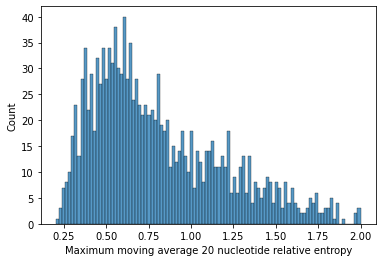

In [15]:
a = sns.histplot(data = [x[1] for x in id_re], bins = 100)
a.set(xlabel ="Maximum moving average 20 nucleotide relative entropy", ylabel = "Count", title ='')

#### BLAST intergenic sequences to assess whether any could be complementary